<font size="6">Tutorial: Unsupervised learning for molecular nonadiabatic dynamics</font> <br><br> <font size="5">Seminars on Machine Learning in Quantum Chemistry and Quantum Computing for Quantum Chemistry (SMLQC)</font> 

In this tutorial, we will see practical examples of using unsupervised machine learning methods **to automate pattern discovery and get chemical insight** from data generated by **nonadiabatic molecular dynamics (NAMD)** simulations. The NAMD data obtained within the **surface hopping** approximation is composed of an ensemble of trajectories that can be viewed as *multivariate time series* objects, where each point in time corresponds to a molecular geometry with its associated quantum properties. Thus, owing to the high dimensionality of the NAMD data, it can be cumbersome to identify the key internal coordinates of the molecule driving the excited-state dynamics by "manual" inspection of the data. This is the scenario where unsupervised learning comes to the rescue. The main idea is to use algorithms designed to find natural grouping structures within the data - **clustering analysis** - or find a compact data representation - **dimension reduction** - based on a given similarity measure between data instances.

To automate the unsupervised learning analysis in the context of nonadiabatic dynamics, we have developed a Python package called [**ULaMDyn**](www.ulamdyn.com), which provides a complete pipeline for analyzing NAMD trajectories data generated by the [**Newton-X**](https://newtonx.org/) program. This pipeline starts with collecting data from the Newton-X outputs, going through molecular representations, dimension reduction, and clustering analysis. Although ULaMDyn provides a friendly-user command-line interface to perform the whole data analysis in a single shot, in this tutorial, we will unfold the pipeline step-by-step to get a better understanding and more flexibility in the data analysis process. 

# Installation of required packages

**Instruction**: If you are running this notebook in Google colab, please restart the execution environment after the packages' installation given by the bash commands below. This is necessary to avoid error when instantiating the classes of ulamdyn.

In [1]:
%%bash

git clone https://gitlab.com/maxjr82/ulamdyn.git
cd ulamdyn
pip install -e .
pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ulamdyn
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 6.4 MB/s eta 0:00:00
  Running setup.py develop for ulamdyn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Cloning into 'ulamdyn'...


# The NAMD dataset: fulvene

The fulvene is used in this tutorial as an example of photoactive molecule that undergoes structural transformation in a nonadiabatic dynamics simulations starting from the first excited-state. To generate the fulvene dataset, the Newton-X program was used to propagate 200 surface hopping trajectories up to 60 fs with a time step of 0.1 fs. The CAS(6,6)/6-31G* method was used to compute the quantum chemical properties for the two electronic states (S$_0$ and S$_1$). For the sake of time and simplicity, only a fraction of the total number of trajectories (50 trajectories) was selected for the tutorial. The full dataset is available to download at https://doi.org/10.6084/m9.figshare.14446998.v1.

In [1]:
%%bash

tar -zxvf nx_trajs_fulv.tgz
rm -rf nx_trajs_fulv.tgz

nx_trajs_fulv/
nx_trajs_fulv/geom.xyz
nx_trajs_fulv/TRAJ1/
nx_trajs_fulv/TRAJ1/jiri.inp
nx_trajs_fulv/TRAJ1/geom
nx_trajs_fulv/TRAJ1/control.dyn
nx_trajs_fulv/TRAJ1/columbus.par
nx_trajs_fulv/TRAJ1/sh.inp
nx_trajs_fulv/TRAJ1/RESULTS/
nx_trajs_fulv/TRAJ1/RESULTS/sh.out
nx_trajs_fulv/TRAJ1/RESULTS/tprob
nx_trajs_fulv/TRAJ1/RESULTS/dyn.out
nx_trajs_fulv/TRAJ1/RESULTS/typeofdyn.log
nx_trajs_fulv/TRAJ1/RESULTS/report.ci
nx_trajs_fulv/TRAJ1/RESULTS/nx.log
nx_trajs_fulv/TRAJ1/RESULTS/properties
nx_trajs_fulv/TRAJ1/RESULTS/intec
nx_trajs_fulv/TRAJ1/RESULTS/en.dat
nx_trajs_fulv/TRAJ1/veloc
nx_trajs_fulv/TRAJ106/
nx_trajs_fulv/TRAJ106/jiri.inp
nx_trajs_fulv/TRAJ106/geom
nx_trajs_fulv/TRAJ106/control.dyn
nx_trajs_fulv/TRAJ106/columbus.par
nx_trajs_fulv/TRAJ106/sh.inp
nx_trajs_fulv/TRAJ106/RESULTS/
nx_trajs_fulv/TRAJ106/RESULTS/sh.out
nx_trajs_fulv/TRAJ106/RESULTS/tprob
nx_trajs_fulv/TRAJ106/RESULTS/dyn.out
nx_trajs_fulv/TRAJ106/RESULTS/typeofdyn.log
nx_trajs_fulv/TRAJ106/RESULTS/report.ci
nx_traj

After downloading and unpacking the NAMD data, we need to move to the working directory that contains the 50 TRAJ folders with the simulation results. ULaMDyn will automatically recognize the available trajectories to extract all the information required to perform the analysis. 

In [2]:
import os

TUTORIAL_DIR = "nx_trajs_fulv"

os.chdir(TUTORIAL_DIR)
os.listdir('./')

['TRAJ80',
 'TRAJ8',
 'TRAJ46',
 'TRAJ197',
 'TRAJ184',
 'TRAJ27',
 'TRAJ174',
 'TRAJ60',
 'TRAJ65',
 'TRAJ41',
 'TRAJ122',
 'TRAJ95',
 'TRAJ51',
 'TRAJ20',
 'TRAJ73',
 'TRAJ163',
 'TRAJ134',
 'geom.xyz',
 'TRAJ21',
 'TRAJ194',
 'TRAJ135',
 'TRAJ156',
 'TRAJ61',
 'TRAJ109',
 'TRAJ75',
 'TRAJ121',
 'TRAJ19',
 'TRAJ107',
 'TRAJ120',
 'TRAJ182',
 'TRAJ67',
 'TRAJ108',
 'TRAJ192',
 'TRAJ62',
 'TRAJ18',
 'TRAJ166',
 'TRAJ3',
 'TRAJ198',
 'TRAJ190',
 'TRAJ119',
 'TRAJ118',
 'TRAJ179',
 'TRAJ1',
 'TRAJ17',
 'TRAJ74',
 'TRAJ106',
 'TRAJ40',
 'TRAJ42',
 'TRAJ9',
 'TRAJ87',
 'TRAJ112']

# ULaMDyn via command-line interface

The command-line interface (CLI) of ULaMDyn provides an alias to a set of predefined wrapper functions to assist through the complete process of performing unsupervised learning analysis on NAMD data. Alternatively, one can also use the CLI to easily extract the relevant computed quantities available in the multiple trajectories and export the collected information as structured datasets in csv format. To check for the options available in the CLI, one can run the help function in a shell terminal.  

In [ ]:
! run-ulamdyn --help

usage: run-ulamdyn
       [-h]
       [--save_dataset]
       [--save_xyz]
       [--use_au]
       [--create_stats]
       [--bootstrap]
       {ring_analysis,dim_reduction,clustering}
       ...

optional arguments:
  -h, --help
    show this
    help
    message and
    exit
  --save_dataset 
     Select data set to build from the MD outputs and save as csv file.
     Options: all, properties, gradients, nacs, velocities, vibspec.
  --save_xyz 
     Write the requested data from all trajectories into XYZ file(s). The argument should be given as a comma separated list of strings,
     starting with geoms or grads and followed by optional subargs (example: "hops" or "hops,S21" or a query in the form "TRAJ==10").
  --use_au
     If selected, the XYZ Cartesian coordinates or gradients will be written in atomic units (useful for MLatom training).
  --create_stats 
     Generate a data set with basic statistics (mean, median, and std) for all the trajectories.
     Options: all, ekin, vib

For a quick demonstration, let us use the command-line interface of ULaMDyn to run a complete clustering analysis with the K-Means method. In the example shown below, we provide the type of data in which the clustering analysis will be performed with the option `-space=geoms` (this means that geometries from different trajectories and time will be compared), then the number of geometries randomly selected from the full dataset is also given (`--n_samples=500`), and finally the descriptor in which the XYZ coordinates will be converted (`--descriptor=RE`).

In [ ]:
! run-ulamdyn clustering --space=geoms --n_samples=500 --descriptor=RE --method=kmeans --n_clusters=2 

The clustering analysis will be performed

Reading geometries from TRAJ1...
Reading geometries from TRAJ2...
Reading geometries from TRAJ3...
Reading geometries from TRAJ4...
Reading geometries from TRAJ5...
Reading geometries from TRAJ6...
Reading geometries from TRAJ7...
Reading geometries from TRAJ8...
Reading geometries from TRAJ9...
Reading geometries from TRAJ10...
Reading geometries from TRAJ11...
Reading geometries from TRAJ12...
Reading geometries from TRAJ13...
Reading geometries from TRAJ14...
Reading geometries from TRAJ15...
Reading geometries from TRAJ16...
Reading geometries from TRAJ17...
Reading geometries from TRAJ18...
Reading geometries from TRAJ19...
Reading geometries from TRAJ20...
Reading geometries from TRAJ21...
Reading geometries from TRAJ22...
Reading geometries from TRAJ23...
Reading geometries from TRAJ24...
Reading geometries from TRAJ25...
Reading geometries from TRAJ26...
Reading geometries from TRAJ27...
Reading geometries from TRAJ28...
Reading geomet

In [ ]:
# Clean the working directory
%%bash

rm -rf kmeans* *.csv

# Step-by-step pipeline for unsupervised analysis

As shown in the CLI example above, ULaMDyn performed the complete clustering analysis in an automated way, starting from the data collection, then converting geometries into a descriptor, and finally running the clustering algorithm on the geometries' space. In addition, the program performed several statistical analysis by groupping the data according the cluster labels provided by the clustering algorithm. In the next, we will unfold this pipeline process to see how ULaMDyn can be used to perform this analysis step-by-step in a Python framework.

In [3]:
import numpy as np
import pandas as pd
import ulamdyn as umd

# Packages for visualization
import py3Dmol
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [61]:
# Plot settings

%matplotlib inline

mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 15

plt.style.use('seaborn-white')
sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white', 
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

In [5]:
def view_molecule(xyz_geom, style):
    
    for k in style.keys():
        assert k in ('line', 'stick', 'sphere', 'carton')
    
    molview = py3Dmol.view(width=350,height=350)
    molview.addModel(xyz_geom,'xyz')
        
    molview.setStyle(style)
    molview.setBackgroundColor('0xeeeeee')
    molview.zoomTo()
    
    return molview

# Read and inspect data

The first step in the pipeline for analyzing the nonadiabatic MD data is to collect the relevant quantities (e.g., molecular geometries, potential energy for each electronic state, kinetic energy, energy-gradients, oscillator strength, etc.) computed by the MD program along each trajectory. In the case of Newton-X CS, this information is typically outputted in unstructured text files that you can find in each `TRAJXX/RESULTS` folder. Thus, ULaMDyn provides built-in classes to collect all these data and stores them in a Python object for easy manipulation. In the next, we will see how these data collection classes can be used in a Python environment.

## Collect molecular geometries from NAMD trajectories

In [6]:
geoms_loader = umd.GetCoords()
geoms_loader.read_all_trajs()

Reading geometries from TRAJ1...
Reading geometries from TRAJ3...
Reading geometries from TRAJ8...
Reading geometries from TRAJ9...
Reading geometries from TRAJ17...
Reading geometries from TRAJ18...
Reading geometries from TRAJ19...
Reading geometries from TRAJ20...
Reading geometries from TRAJ21...
Reading geometries from TRAJ27...
Reading geometries from TRAJ40...
Reading geometries from TRAJ41...
Reading geometries from TRAJ42...
Reading geometries from TRAJ46...
Reading geometries from TRAJ51...
Reading geometries from TRAJ60...
Reading geometries from TRAJ61...
Reading geometries from TRAJ62...
Reading geometries from TRAJ65...
Reading geometries from TRAJ67...
Reading geometries from TRAJ73...
Reading geometries from TRAJ74...
Reading geometries from TRAJ75...
Reading geometries from TRAJ80...
Reading geometries from TRAJ87...
Reading geometries from TRAJ95...
Reading geometries from TRAJ106...
Reading geometries from TRAJ107...
Reading geometries from TRAJ108...
Reading geometr

In [7]:
print(geoms_loader)

Data loader object to read molecular geometries from NAMD trajectories.

Current state of the class variables:
---------------------------------------
 • Trajectories read -> ['TRAJ1', 'TRAJ3', 'TRAJ8', 'TRAJ9', 'TRAJ17', 'TRAJ18', 'TRAJ19', 'TRAJ20', 'TRAJ21', 'TRAJ27', 'TRAJ40', 'TRAJ41', 'TRAJ42', 'TRAJ46', 'TRAJ51', 'TRAJ60', 'TRAJ61', 'TRAJ62', 'TRAJ65', 'TRAJ67', 'TRAJ73', 'TRAJ74', 'TRAJ75', 'TRAJ80', 'TRAJ87', 'TRAJ95', 'TRAJ106', 'TRAJ107', 'TRAJ108', 'TRAJ109', 'TRAJ112', 'TRAJ118', 'TRAJ119', 'TRAJ120', 'TRAJ121', 'TRAJ122', 'TRAJ134', 'TRAJ135', 'TRAJ156', 'TRAJ163', 'TRAJ166', 'TRAJ174', 'TRAJ179', 'TRAJ182', 'TRAJ184', 'TRAJ190', 'TRAJ192', 'TRAJ194', 'TRAJ197', 'TRAJ198']
 • Atom labels -> ['C' 'C' 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H']
 • Total number of geometries -> 30028



Once all molecular geometries have been collected and loaded into the class variable, one can easily access any particular geometry of the dataset in the XYZ format by specifying the `TRAJ` and `time` indices. Then, the selected geometry can be visualized in the Jupyter notebook by using py3Dmol.

In [11]:
# Select geometry either from trajectory and time indices
# or by the geometry number in the loaded dataset.
geometry = geoms_loader[9,10.0]
print(geometry)

12
TRAJ = 9  |  time = 10.0
C       -1.14129561   0.30153288   0.08021860 
C       -1.23110232  -1.25788554  -0.13179371 
C       -0.07435951  -1.75000435  -0.09788153 
C        0.95423784  -0.58499986  -0.04235871 
C        0.21210668   0.49649174   0.01379727 
C        0.85008289   1.89603152  -0.05137523 
H       -1.92567948   0.89066332   0.10502466 
H       -2.05573125  -1.63342028  -0.05590450 
H        0.24561836  -2.77927289   0.14463123 
H        1.94229201  -0.63386124  -0.11949176 
H        0.39591327   2.99931110  -0.10749780 
H        1.82791710   2.05541359   0.26263146 



In [12]:
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
view_molecule(geometry, s)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If a reference geometry named `geom.xyz` is available in the working directory, the `read_all_trajs()` method will compute, by default, the RMSD between each current geometry read from the trajectories and a given reference geometry. In our example, the reference geometry is the ground-state one (S$_0$ minimum). For some unsupervised learning algorithms implemented in ULaMDyn, it is also possible to use the RMSD as a distance metric to compare pair of geometries.

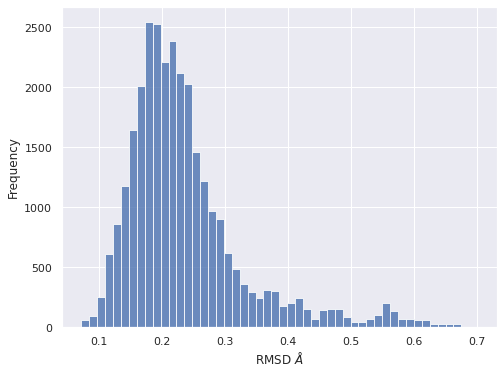

In [13]:
rmsd_vals = geoms_loader.rmsd
hist = plt.hist(rmsd_vals, bins=50, alpha=0.8)
plt.xlabel(r"RMSD $\AA$")
plt.ylabel("Frequency")
plt.show()

## Build dataset with chemical properties

The quantum mechanical quantities such as potential energies and oscillator strength are collected from the Newton-X outputs using the `GetProperties` class. In the case of fulvene dynamics, we have available the potential energy of the ground and first excited-state, the oscillator strength corresponding to the transition between these two states, and also the MCSCF coefficients of the CAS wave function. In addition, there is also a function to collect the state's population computed by Newton-X. In the next cells, we will see examples of how to extract these data.

In [14]:
properties_loader = umd.GetProperties()

In [15]:
df_props = properties_loader.energies()

Reading energies from TRAJ1...
Reading energies from TRAJ3...
Reading energies from TRAJ8...
Reading energies from TRAJ9...
Reading energies from TRAJ17...
Reading energies from TRAJ18...
Reading energies from TRAJ19...
Reading energies from TRAJ20...
Reading energies from TRAJ21...
Reading energies from TRAJ27...
Reading energies from TRAJ40...
Reading energies from TRAJ41...
Reading energies from TRAJ42...
Reading energies from TRAJ46...
Reading energies from TRAJ51...
Reading energies from TRAJ60...
Reading energies from TRAJ61...
Reading energies from TRAJ62...
Reading energies from TRAJ65...
Reading energies from TRAJ67...
Reading energies from TRAJ73...
Reading energies from TRAJ74...
Reading energies from TRAJ75...
Reading energies from TRAJ80...
Reading energies from TRAJ87...
Reading energies from TRAJ95...
Reading energies from TRAJ106...
Reading energies from TRAJ107...
Reading energies from TRAJ108...
Reading energies from TRAJ109...
Reading energies from TRAJ112...
Reading

In [16]:
df_props

,TRAJ,time,State,Total_Energy,DE21,Hops_S21,S1,Hops_S12
0,1,0.0,2,-6271.713990,3.852182,0,-6276.740507,0
1,1,0.1,2,-6271.714018,3.839637,0,-6276.777841,0
2,1,0.2,2,-6271.714045,3.825025,0,-6276.812753,0
3,1,0.3,2,-6271.714072,3.808371,0,-6276.844754,0
4,1,0.4,2,-6271.714099,3.789650,0,-6276.873408,0
...,...,...,...,...,...,...,...,...
30023,198,59.6,1,-6272.098760,5.787729,0,-6274.737912,0
30024,198,59.7,1,-6272.098787,5.832736,0,-6274.767898,0
30025,198,59.8,1,-6272.098814,5.876383,0,-6274.799437,0
30026,198,59.9,1,-6272.098841,5.918697,0,-6274.832036,0


Note that, for consistency, the datasets generated by ULaMDyn will contain two primary indices, corresponding to the columns `TRAJ` and `time`, which allow to identify each data point in the whole set of NAMD trajectories available.

In [17]:
_ = properties_loader.populations()

Reading populations from TRAJ1...
Reading populations from TRAJ3...
Reading populations from TRAJ8...
Reading populations from TRAJ9...
Reading populations from TRAJ17...
Reading populations from TRAJ18...
Reading populations from TRAJ19...
Reading populations from TRAJ20...
Reading populations from TRAJ21...
Reading populations from TRAJ27...
Reading populations from TRAJ40...
Reading populations from TRAJ41...
Reading populations from TRAJ42...
Reading populations from TRAJ46...
Reading populations from TRAJ51...
Reading populations from TRAJ60...
Reading populations from TRAJ61...
Reading populations from TRAJ62...
Reading populations from TRAJ65...
Reading populations from TRAJ67...
Reading populations from TRAJ73...
Reading populations from TRAJ74...
Reading populations from TRAJ75...
Reading populations from TRAJ80...
Reading populations from TRAJ87...
Reading populations from TRAJ95...
Reading populations from TRAJ106...
Reading populations from TRAJ107...
Reading populations fr

In [18]:
df_props = properties_loader.dataset
df_props

,TRAJ,time,State,Total_Energy,DE21,Hops_S21,S1,Hops_S12,Pop1,Pop2
0,1,0.0,2,-6271.713990,3.852182,0,-6276.740507,0,0.000000,1.000000e+00
1,1,0.1,2,-6271.714018,3.839637,0,-6276.777841,0,0.000001,9.999989e-01
2,1,0.2,2,-6271.714045,3.825025,0,-6276.812753,0,0.000004,9.999964e-01
3,1,0.3,2,-6271.714072,3.808371,0,-6276.844754,0,0.000006,9.999936e-01
4,1,0.4,2,-6271.714099,3.789650,0,-6276.873408,0,0.000008,9.999916e-01
...,...,...,...,...,...,...,...,...,...,...
30023,198,59.6,1,-6272.098760,5.787729,0,-6274.737912,0,1.000000,1.123522e-09
30024,198,59.7,1,-6272.098787,5.832736,0,-6274.767898,0,1.000000,2.989686e-09
30025,198,59.8,1,-6272.098814,5.876383,0,-6274.799437,0,1.000000,6.379101e-09
30026,198,59.9,1,-6272.098841,5.918697,0,-6274.832036,0,1.000000,1.154264e-08


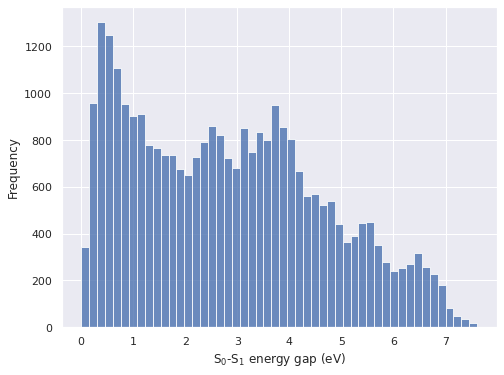

In [19]:
egap = df_props['DE21'].values
hist = plt.hist(egap, bins=50, alpha=0.8)
plt.xlabel(r"S$_0$-S$_1$ energy gap (eV)")
plt.ylabel("Frequency")
plt.show()

## Geometry-based descriptors

In [20]:
geoms_loader.xyz

array([[[-1.17011027,  0.32892165, -0.04880431],
        [-1.33595893, -1.10235717,  0.08826031],
        [ 0.07813233, -1.68450973,  0.08371418],
        ...,
        [ 2.08413222, -0.56710914,  0.04163883],
        [ 0.36090265,  2.80427644,  0.15999523],
        [ 1.87742744,  2.07998925,  0.06344612]],

       [[-1.17009904,  0.32722287, -0.04883062],
        [-1.3352209 , -1.10354471,  0.08816412],
        [ 0.07797813, -1.68578747,  0.08389662],
        ...,
        [ 2.0835327 , -0.56644704,  0.04307052],
        [ 0.35768954,  2.80912331,  0.16216635],
        [ 1.87931688,  2.07674128,  0.0627888 ]],

       [[-1.17003061,  0.32551303, -0.04884248],
        [-1.33436844, -1.10473665,  0.08806767],
        [ 0.0778281 , -1.68704068,  0.08407352],
        ...,
        [ 2.0828739 , -0.56582214,  0.04446104],
        [ 0.35444625,  2.81379853,  0.16432876],
        [ 1.8812048 ,  2.07338819,  0.06213557]],

       ...,

       [[-1.25487261,  0.20365817,  0.01472899],
        [-1

In ULaMDyn, there are two classes of **symmetry-aware descriptors** (translational and rotational invariant) based on molecular geometries: the **pairwise atom-atom distances** (R2 family of descriptors) and the **Z-Matrix** representation. Each one of these descriptors is handled by Python classes that take a `GetCoords()` object as input to access the NAMD molecular geometries and convert them into the specified descriptor type. As you will see in the example below, the R2 descriptor class contains the function `build_descriptor()`, which returns a Pandas data frame object with the descriptor calculated for all geometries of each NAMD trajectory. Other variants of the R2 descriptor supported by this function include:

- *inv-R2* -> inverse of the R2 matrix
- *delta-R2* -> difference in the R2 descriptor of each MD frame and a reference geometry
- *RE* -> inverse R2 of each MD frame normalized by the R2 vector of a reference geometry 

In [21]:
atom_dist = umd.R2(geoms_loader)
df_r2 = atom_dist.build_descriptor(variant='R2')
df_r2.head()

,TRAJ,time,r12,r13,r23,r14,r24,r34,r15,r25,...,r212,r312,r412,r512,r612,r712,r812,r912,r1012,r1112
0,1,0.0,1.447360,2.372673,1.529240,2.392659,2.373981,1.365330,1.395893,2.297261,...,4.522587,4.172448,2.914349,2.236683,1.091192,4.006476,5.540837,5.098959,2.655246,1.683378
1,1,0.1,1.446765,2.372240,1.528449,2.392770,2.374176,1.366707,1.397138,2.297722,...,4.521959,4.171557,2.911907,2.235791,1.090342,4.008308,5.543325,5.095413,2.651139,1.691629
2,1,0.2,1.446155,2.371748,1.527545,2.392830,2.374330,1.368172,1.398351,2.298104,...,4.521179,4.170548,2.909249,2.234833,1.089398,4.010258,5.545897,5.091789,2.646963,1.699895
3,1,0.3,1.445535,2.371200,1.526529,2.392841,2.374441,1.369723,1.399532,2.298409,...,4.520252,4.169425,2.906380,2.233810,1.088363,4.012306,5.548541,5.088094,2.642723,1.708158
4,1,0.4,1.444908,2.370599,1.525402,2.392807,2.374513,1.371358,1.400684,2.298639,...,4.519182,4.168190,2.903305,2.232728,1.087243,4.014435,5.551243,5.084338,2.638424,1.716401


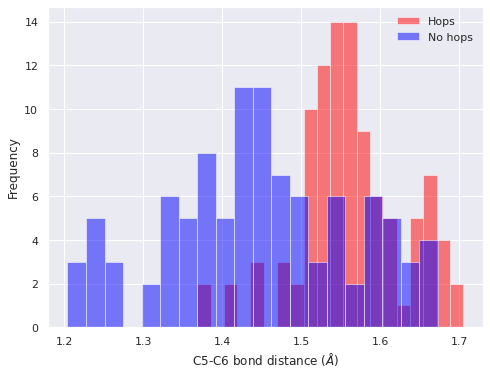

In [22]:
idx_all_hops = df_props.query("Hops_S21 == 1").index.tolist() + df_props.query("Hops_S12 == 1").index.tolist()
idx_no_hops = df_props.query("Hops_S21 == 0 and Hops_S12 == 0").index.tolist()

h1 = plt.hist(df_r2.iloc[idx_all_hops]['r56'], bins=20, color='red', alpha=0.5, label='Hops')
h2 = plt.hist(df_r2.iloc[idx_no_hops]['r56'].sample(len(idx_all_hops)), bins=20, color='blue', 
              alpha=0.5, label='No hops')
plt.xlabel(r"C5-C6 bond distance ($\AA$)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

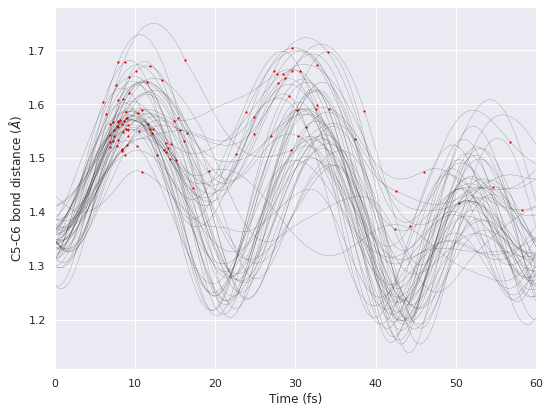

In [23]:
for traj in df_r2['TRAJ'].unique():
  t = df_r2.query(f"TRAJ == {traj}")['time'].values
  c5_c6_dist = df_r2.query(f"TRAJ == {traj}")['r56'].values
  plt.plot(t, c5_c6_dist, c='k', lw=0.3, alpha=0.5)
plt.scatter(df_r2.iloc[idx_all_hops]['time'], df_r2.iloc[idx_all_hops]['r56'], 
            color='red', s=1.5)  
plt.xlabel("Time (fs)")
plt.ylabel(r"C5-C6 bond distance ($\AA$)")
plt.xlim(0,60)
plt.tight_layout()
plt.show() 

## Dimensionality reduction

In unsupervised learning analysis, dimensionality reduction is a key concept that refers to the process of reducing the number of features or variables in a dataset. **The main goal is to find a low-dimensional representation of the data while still capturing the most important information contained in the data**, thereby reducing the complexity of the analysis. This is important because as the number of features or variables increases, the difficulty of visualizing and analyzing the data also increases. By compressing the data in a meaningful way, it becomes easier to identify patterns, relationships, and clusters within the data. There are various techniques used in dimension reduction, including *principal component analysis* (PCA), *isometric feature mapping* (Isomap), and *t-distributed stochastic neighbor embedding* (t-SNE), each of which has its own strengths and weaknesses. These algorithms can be used either as a data exploration tool for visual inspection of the data structure via scatter plots or as a preprocessing step to provide effectively compact input data for supervised learning methods.

In [24]:
dimred = umd.DimensionReduction(data=df_r2, dt=0.5, scaler='standard')


Scaling data with standard method



In the example below, we will use the [Isomap algorithm](https://www.science.org/doi/10.1126/science.290.5500.2319), which is a manifold learning technique used as a non-linear feature reduction method that aims at preserving the geodesic distances between data points in the low-dimensional space. In a nutshell, the Isomap algorithm works as follows:

1. Compute the pairwise distances between all data points in the original high-dimensional space to determine the neighbors of each point (fixed radius or KNN);
2. Compute the shortest path distances between all pairs of data points using a distance preserving graph algorithm, such as Dijkstra's algorithm;
3. Embed the data points in a low-dimensional space (e.g., two or three dimensions) by finding a low-dimensional representation that minimizes the difference between the pairwise distances in the high-dimensional space and the pairwise distances in the low-dimensional space. This is done using classical multidimensional scaling (MDS).

In [25]:
df_isomap = dimred.isomap(n_components=2)

***********************************
*  Starting the Isomap analysis:  *
***********************************

 The following set of parameters will be used:

            n_neighbors = 30                  
           n_components = 2                   
           eigen_solver = auto                
                    tol = 0                   
               max_iter = None                
            path_method = auto                
    neighbors_algorithm = auto                
                 n_jobs = -1                  
                 metric = cosine              
                      p = 2                   
          metric_params = None                
 


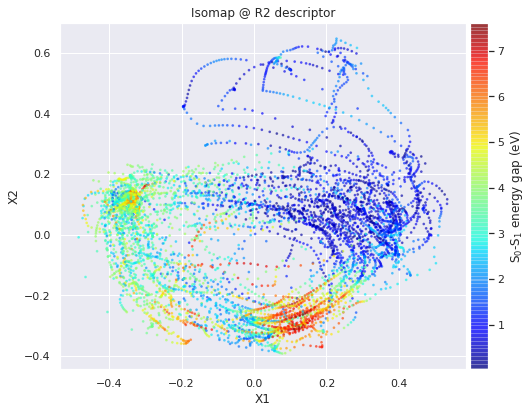

In [26]:
idx = df_isomap.index.tolist()
colors = df_props['DE21'].iloc[idx].values
plt.scatter(df_isomap['X1'], df_isomap['X2'], c=colors, cmap='jet', s=3.0, alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Isomap @ R2 descriptor')
cbar = plt.colorbar(pad=0.01)
cbar.set_label(r"S$_0$-S$_1$ energy gap (eV)")
plt.tight_layout()
plt.show()

Note that, in the two-dimensional representation of the R2 descriptor generated by Isomap, the molecular geometries characterized by a large energy gap (red dots) appear separated from those corresponding to a small energy gap (blue dots). This qualitative picture indicates that the geometries near the crossing seams should have distinguished features compared to the other geometries.

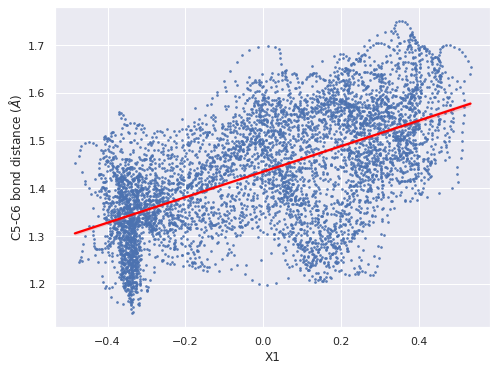

In [27]:
sns.regplot(df_isomap['X1'], df_r2.iloc[idx]['r56'], scatter_kws={'s': 3.0},
            line_kws={'color':'red'})
plt.ylabel(r"C5-C6 bond distance ($\AA$)")
plt.show()

In nonlinear dimensionality reduction, finding the relationship between the embedded dimensions and the original features to determine which one is contributing the most to the clustering patterns is usually complicated. One alternative to get an intuition about those relationships is to plot each geometrical feature of the molecules against the embedded dimensions.

## Gradient-based descriptors

In [28]:
grads_loader = umd.GetGradients()
grads_loader.build_dataframe()

Reading gradients from TRAJ1...
Reading gradients from TRAJ3...
Reading gradients from TRAJ8...
Reading gradients from TRAJ9...
Reading gradients from TRAJ17...
Reading gradients from TRAJ18...
Reading gradients from TRAJ19...
Reading gradients from TRAJ20...
Reading gradients from TRAJ21...
Reading gradients from TRAJ27...
Reading gradients from TRAJ40...
Reading gradients from TRAJ41...
Reading gradients from TRAJ42...
Reading gradients from TRAJ46...
Reading gradients from TRAJ51...
Reading gradients from TRAJ60...
Reading gradients from TRAJ61...
Reading gradients from TRAJ62...
Reading gradients from TRAJ65...
Reading gradients from TRAJ67...
Reading gradients from TRAJ73...
Reading gradients from TRAJ74...
Reading gradients from TRAJ75...
Reading gradients from TRAJ80...
Reading gradients from TRAJ87...
Reading gradients from TRAJ95...
Reading gradients from TRAJ106...
Reading gradients from TRAJ107...
Reading gradients from TRAJ108...
Reading gradients from TRAJ109...
Reading gr

In [29]:
df_gdiff = grads_loader.datasets['S2'] - grads_loader.datasets['S1']
df_gdiff.insert(0, "TRAJ", df_props['TRAJ'].values)
df_gdiff.insert(1, "time", df_props['time'].values)
df_gdiff.head()

,TRAJ,time,Gx1,Gy1,Gz1,Gx2,Gy2,Gz2,Gx3,Gy3,...,Gz9,Gx10,Gy10,Gz10,Gx11,Gy11,Gz11,Gx12,Gy12,Gz12
0,1,0.0,-3.995985,-3.634359,0.102500,-2.309150,5.699686,-0.523269,6.311249,2.122976,...,0.190308,0.013113,-0.002946,-0.123871,-0.098520,0.096437,-0.291259,0.130365,-0.017000,-0.137181
1,1,0.1,-3.992956,-3.643739,0.104824,-2.320324,5.701558,-0.522106,6.310457,2.122704,...,0.192587,0.013431,-0.003409,-0.125089,-0.096668,0.095532,-0.292995,0.129690,-0.016902,-0.137010
2,1,0.2,-3.989125,-3.652717,0.107128,-2.332208,5.703425,-0.520901,6.310272,2.122282,...,0.194784,0.013719,-0.003893,-0.126216,-0.094840,0.094581,-0.294662,0.128976,-0.016846,-0.136834
3,1,0.3,-3.984472,-3.661639,0.109390,-2.344914,5.705446,-0.519626,6.310493,2.121660,...,0.196892,0.013971,-0.004412,-0.127229,-0.093038,0.093588,-0.296275,0.128224,-0.016830,-0.136662
4,1,0.4,-3.979005,-3.670339,0.111612,-2.358433,5.707595,-0.518279,6.311152,2.120817,...,0.198907,0.014177,-0.004962,-0.128123,-0.091271,0.092560,-0.297834,0.127439,-0.016851,-0.136492


In [30]:
dimred = umd.DimensionReduction(data=df_gdiff, dt=0.5, scaler='standard')
df_isomap = dimred.isomap(n_components=2, metric='euclidean')


Scaling data with standard method

***********************************
*  Starting the Isomap analysis:  *
***********************************

 The following set of parameters will be used:

            n_neighbors = 30                  
           n_components = 2                   
           eigen_solver = auto                
                    tol = 0                   
               max_iter = None                
            path_method = auto                
    neighbors_algorithm = auto                
                 n_jobs = -1                  
                 metric = euclidean           
                      p = 2                   
          metric_params = None                
 


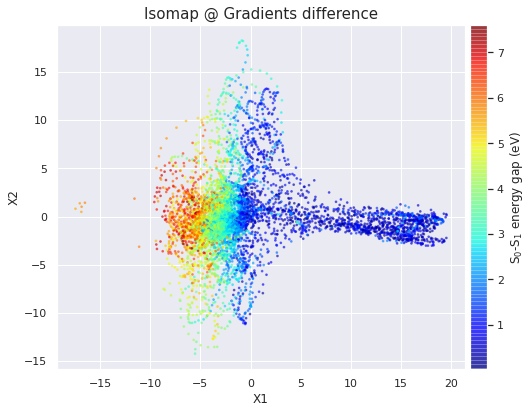

In [31]:
idx = df_isomap.index.tolist()
colors = df_props['DE21'].iloc[idx].values
plt.scatter(df_isomap['X1'], df_isomap['X2'], c=colors, cmap='jet', s=3.0, alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Isomap @ Gradients difference', fontsize=15)
cbar = plt.colorbar(pad=0.01)
cbar.set_label(r"S$_0$-S$_1$ energy gap (eV)")
plt.tight_layout()
plt.show()

Although the Isomap diagram derived from the gradient difference descriptors looks different from the one obtained with the R2 descriptor (geometry-based), one can observe that geometries with small and large energy gaps between the S$_0$ and S$_1$ states still appear as distinct groups in the plot.

## Clustering analysis

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is a subfield of unsupervised data analysis where the learning task consists of finding commonalities in a set of objects so that objects sharing a high similarity with respect to a given metric fall into the same group (called a cluster). In contrast, dissimilar objects are assigned to distinct groups. In principle, it is not required to perform dimensionality reduction prior to clustering analysis since the similarity metric used to compare pairs of data points can be computed in the original high-dimensional space of the data. However, datasets with a very large number of features may lead to the curse of dimensionality problem, which tends to degrade the performance of clustering algorithms. So, in this case, it might be recommended to reduce the dimension of the data before applying a clustering method.

There are many different algorithms to perform clustering analysis that differ essentially in the understanding of what constitutes a cluster and how to find them. The algorithms available in ULaMDyn for clustering analysis are:

+ K-Means clustering
+ Hierarchical agglomerative clustering
+ Spectral clustering (equivalent to kernel K-Means)

**Primary goal**: split the NAMD dataset into smaller subgroups of similar molecular geometries to facilitate the identification of the key active internal coordinates related to the photochemical process. 

In [32]:
zmt = umd.ZMatrix(geoms_loader)
df_dzmt = zmt.build_descriptor(delta=True, apply_to_delta='sigmoid')

In [33]:
clustering = umd.ClusterGeoms(data=df_dzmt, dt=0.5, scaler='standard')
#clustering = umd.ClusterGeoms(data=df_gdiff, dt=0.5, scaler='standard')


Scaling data with standard method



In [34]:
df_kmeans = clustering.kmeans(n_clusters=3)


***********************************************
*  Starting the K-Means clustering analysis:  *
***********************************************

 The following set of parameters will be used:

             n_clusters = 3                   
                   init = k-means++           
               max_iter = 1000                
                    tol = 1e-06               
                 n_init = 500                 
                verbose = 0                   
           random_state = 42                  
                 copy_x = True                
              algorithm = auto                
 
____________________________________
 Number of geometries per cluster:

       cluster 0 ---> 2673  
       cluster 1 ---> 539   
       cluster 2 ---> 2833  
____________________________________
 


In [35]:
df_cluster = pd.merge(df_props, df_kmeans, left_index=True, right_index=True)
df_cluster

,TRAJ,time,State,Total_Energy,DE21,Hops_S21,S1,Hops_S12,Pop1,Pop2,kmeans_labels
0,1,0.0,2,-6271.713990,3.852182,0,-6276.740507,0,0.000000,1.000000e+00,0
5,1,0.5,2,-6271.714099,3.768888,0,-6276.898361,0,0.000009,9.999911e-01,0
10,1,1.0,2,-6271.714099,3.635252,0,-6276.962906,0,0.000002,9.999979e-01,0
15,1,1.5,2,-6271.714018,3.454052,0,-6276.932075,0,0.000007,9.999926e-01,0
20,1,2.0,2,-6271.713936,3.229667,0,-6276.831883,0,0.000010,9.999897e-01,2
...,...,...,...,...,...,...,...,...,...,...,...
30007,198,58.0,1,-6272.098624,4.930733,0,-6274.800008,0,1.000000,8.184168e-09,0
30012,198,58.5,1,-6272.098542,5.220670,0,-6274.642971,0,1.000000,1.938768e-09,0
30017,198,59.0,1,-6272.098569,5.493083,0,-6274.618780,0,1.000000,4.262358e-09,0
30022,198,59.5,1,-6272.098705,5.741524,0,-6274.710047,0,1.000000,4.785683e-10,0


In [36]:
select_cols = ['time', 'DE21', 'Hops_S21', 'Hops_S12']
df_cluster.groupby(by=['kmeans_labels']).mean()[select_cols].reset_index()

,kmeans_labels,time,DE21,Hops_S21,Hops_S12
0,0,37.151515,4.508799,0.000000,0.000000
1,1,42.723562,1.339882,0.003711,0.000000
2,2,20.780445,1.555672,0.003177,0.001412


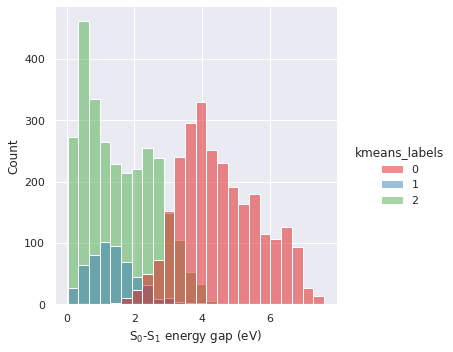

In [37]:
sns.displot(data=df_cluster, x="DE21", hue="kmeans_labels", palette="Set1")
plt.xlabel(r"S$_0$-S$_1$ energy gap (eV)")
plt.show()

Once the cluster labels have been determined, we can use the Isomap low-dimensional representation to visualize how the data points are distributed in clusters. This is helpful to check the effectiveness of the clustering algorithm in identifying groups of similar data points.

In [43]:
dimred = umd.DimensionReduction(data=df_dzmt, dt=0.5, scaler='standard')
df_isomap = dimred.isomap(n_components=2, metric='euclidean')
df_isomap = pd.merge(df_isomap, df_kmeans, left_index=True, right_index=True)


Scaling data with standard method

***********************************
*  Starting the Isomap analysis:  *
***********************************

 The following set of parameters will be used:

            n_neighbors = 30                  
           n_components = 2                   
           eigen_solver = auto                
                    tol = 0                   
               max_iter = None                
            path_method = auto                
    neighbors_algorithm = auto                
                 n_jobs = -1                  
                 metric = euclidean           
                      p = 2                   
          metric_params = None                
 


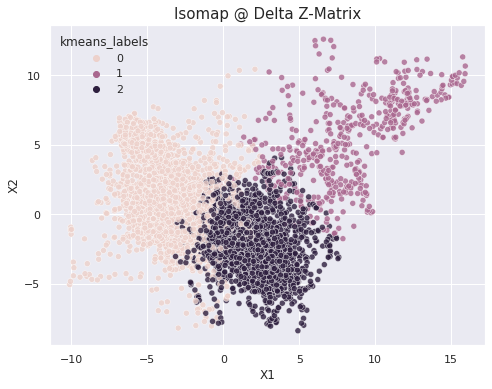

In [44]:
sns.scatterplot(data=df_isomap, x='X1', y='X2', hue='kmeans_labels', alpha=0.8)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Isomap @ Delta Z-Matrix', fontsize=15)
plt.show()

In [45]:
zmat = umd.ZMatrix(geoms_loader)
df_zmt = zmat.build_descriptor()
df_zmt = pd.merge(df_zmt, df_kmeans, left_index=True, right_index=True)
df_zmt.head()

,TRAJ,time,r21,r32,r43,r54,r65,r71,r82,r93,...,d4321,d5432,d6543,d7123,d8213,d9321,d10432,d11654,d12654,kmeans_labels
0,1,0.0,1.447360,1.529240,1.365330,1.524298,1.338307,0.995543,1.019582,1.051487,...,-3.223870,9.300478,172.316382,171.230514,-173.922934,-159.814224,161.757855,-173.820349,-9.632035,0
5,1,0.5,1.444278,1.524166,1.373076,1.518747,1.344414,1.036955,1.037297,1.044822,...,-3.311373,9.160352,171.932151,171.209759,-174.687412,-159.289842,160.991317,-173.240792,-8.931099,0
10,1,1.0,1.441208,1.516387,1.382832,1.510701,1.354165,1.083254,1.059178,1.041370,...,-3.366445,8.966530,171.570774,171.218018,-175.432781,-158.825301,160.398034,-172.673497,-8.168832,0
15,1,1.5,1.438597,1.506085,1.394343,1.500289,1.367334,1.129308,1.082647,1.041649,...,-3.390897,8.722355,171.230920,171.252786,-176.144431,-158.428343,159.985230,-172.103087,-7.361343,0
20,1,2.0,1.436835,1.493481,1.407330,1.487681,1.383574,1.171135,1.105279,1.045731,...,-3.386561,8.431232,170.910728,171.311978,-176.812617,-158.107017,159.757299,-171.516341,-6.525217,2


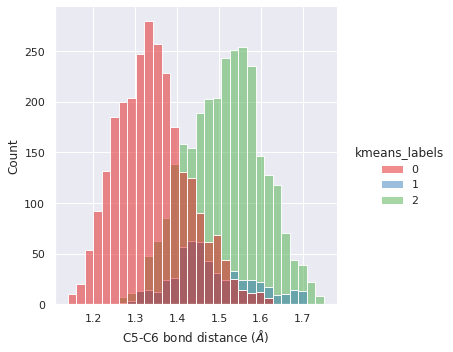

In [46]:
sns.displot(data=df_zmt, x="r65", hue="kmeans_labels", palette="Set1")
plt.xlabel(r"C5-C6 bond distance ($\AA$)")
plt.show()

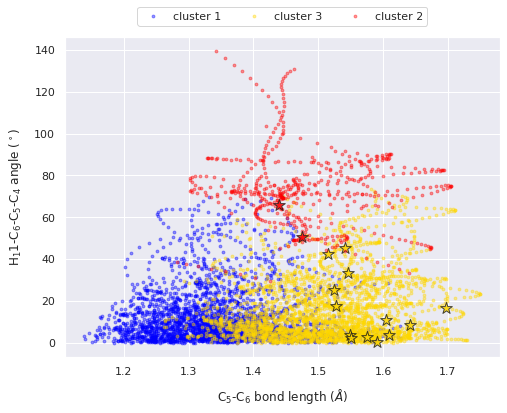

In [64]:
cluster_labels = list(df_zmt['kmeans_labels'].unique())

colors = ['blue', 'gold', 'red']
idx_hops = df_cluster[(df_cluster['Hops_S21'] == 1) | (df_cluster['Hops_S12'] == 1)].index.tolist()

for l,c in zip(cluster_labels, colors):
    zmt = df_zmt[df_zmt['kmeans_labels'] == l].abs()
    plt.scatter(zmt['r65'], zmt['d12654'], s=8, c=c, alpha=0.4, 
                label='cluster ' + str(l))
    df_zmt_hops = df_zmt.abs().loc[idx_hops]
    zmt = df_zmt_hops[df_zmt_hops['kmeans_labels'] == l]
    if zmt.shape[0] != 0:
        plt.scatter(zmt['r65'], zmt['d12654'], s=150, alpha=0.8, marker='*', 
                    edgecolors='k', c=c)

plt.ylabel('H$_11$-C$_6$-C$_5$-C$_4$ angle ($^\circ$)', labelpad=10)
plt.xlabel('C$_5$-C$_6$ bond length ($\AA$)', labelpad=10)
plt.legend(**legend_settings)
plt.show()

In [40]:
traj, time = df_cluster.query("kmeans_labels == 1").sample(1)[['TRAJ', 'time']].values.flatten()
print(f"  Geometry for TRAJ{int(traj)} | time = {time} fs")
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
view_molecule(geoms_loader[traj, time], s)

  Geometry for TRAJ61 | time = 46.5 fs


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol